# Labor Market Analysis

In [281]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

nlp = spacy.load('en_core_web_lg')

### Load data and show columns

In [198]:
df = pd.read_csv('data\\datajobposts.csv')
print(df.columns.values)

['jobpost' 'date' 'Title' 'Company' 'AnnouncementCode' 'Term' 'Eligibility'
 'Audience' 'StartDate' 'Duration' 'Location' 'JobDescription'
 'JobRequirment' 'RequiredQual' 'Salary' 'ApplicationP' 'OpeningDate'
 'Deadline' 'Notes' 'AboutC' 'Attach' 'Year' 'Month' 'IT']


In [199]:
df.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\r\n...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\r\n- CV; \...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


### Remove empty cells in target columns

In [200]:
df = df.dropna(subset=['Title', 'JobDescription', 'Year'])

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15091 entries, 0 to 19000
Data columns (total 24 columns):
jobpost             15091 non-null object
date                15091 non-null object
Title               15091 non-null object
Company             15091 non-null object
AnnouncementCode    970 non-null object
Term                6695 non-null object
Eligibility         3615 non-null object
Audience            459 non-null object
StartDate           7932 non-null object
Duration            9050 non-null object
Location            15079 non-null object
JobDescription      15091 non-null object
JobRequirment       13129 non-null object
RequiredQual        15082 non-null object
Salary              8104 non-null object
ApplicationP        15091 non-null object
OpeningDate         14609 non-null object
Deadline            15073 non-null object
Notes               1685 non-null object
AboutC              10162 non-null object
Attach              948 non-null object
Year                1

### Clean up titles

In [202]:
df['Title'].head()

0                Chief Financial Officer
2                    Country Coordinator
3                         BCC Specialist
5                             Saleswoman
6    Chief Accountant/ Finance Assistant
Name: Title, dtype: object

In [203]:
def cleanTitles(sentence):
    newsent = ''.join(c for c in sentence if c not in punctuation)
    return ' '.join([x for x in newsent.split() if x.lower() not in STOP_WORDS])

df['cleanTitle'] = df.apply(lambda row: cleanTitles(row['Title']), axis=1)

In [204]:
df['cleanTitle'].head()

0               Chief Financial Officer
2                   Country Coordinator
3                        BCC Specialist
5                            Saleswoman
6    Chief Accountant Finance Assistant
Name: cleanTitle, dtype: object

### Clean up Descriptions

#### Remove description stopwords

In [205]:
df['JobDescription'][0]

"AMERIA Investment Consulting Company is seeking a\r\nChief Financial Officer. This position manages the company's fiscal and\r\nadministrative functions, provides highly responsible and technically\r\ncomplex staff assistance to the Executive Director. The work performed\r\nrequires a high level of technical proficiency in financial management\r\nand investment management, as well as management, supervisory, and\r\nadministrative skills."

In [206]:
def removeStopWords(description):
    return ' '.join([x for x in description.split() if x.lower() not in STOP_WORDS])

df['cleandesc'] = df.apply(lambda row: removeStopWords(row['JobDescription']), axis=1)

In [207]:
df['cleandesc'][0]

"AMERIA Investment Consulting Company seeking Chief Financial Officer. position manages company's fiscal administrative functions, provides highly responsible technically complex staff assistance Executive Director. work performed requires high level technical proficiency financial management investment management, management, supervisory, administrative skills."

#### Count most popular words
In this section, we'll find low-signal across all job postings, such as "job" and "performance", and manually add them to the list.  This is because there are some high-signal words at the top, such as "software".

In [210]:
alldescs = ' '.join(df['cleandesc'].values)
alldescs = ' '.join(alldescs.split())

wordcount = {}

for i in alldescs.lower().split():
    if i in wordcount: 
        wordcount[i] += 1
    else:
        wordcount[i] = 1
        
sorted_wordcount = sorted(wordcount.items(), key=lambda x: x[1], reverse=True)

In [211]:
sorted_wordcount

[('responsible', 4711),
 ('looking', 4290),
 ('incumbent', 3840),
 ('position', 3717),
 ('development', 3538),
 ('seeking', 3015),
 ('project', 2809),
 ('work', 2793),
 ('software', 2136),
 ('support', 2044),
 ('armenia', 1814),
 ('team', 1811),
 ('manager', 1713),
 ('management', 1712),
 ('-', 1712),
 ('candidate', 1681),
 ('llc', 1645),
 ('implementation', 1491),
 ('activities', 1454),
 ('company', 1424),
 ('financial', 1380),
 ('provide', 1322),
 ('technical', 1303),
 ('supervision', 1301),
 ('business', 1288),
 ('office', 1264),
 ('sales', 1259),
 ('specialist', 1246),
 ('qualified', 1238),
 ('program', 1224),
 ('senior', 1197),
 ('international', 1145),
 ('services', 1107),
 ('cjsc', 1102),
 ('highly', 1085),
 ('experienced', 1059),
 ('working', 1039),
 ('motivated', 1011),
 ('design', 996),
 ('web', 987),
 ('marketing', 976),
 ('quality', 959),
 ('engineer', 946),
 ('he/', 904),
 ('ensure', 892),
 ('developer', 882),
 ('armenian', 876),
 ('administrative', 866),
 ("company's", 85

From this list, we'll select the words that may help in clearing up the clustering.

In [212]:
custom_stopwords = [
    'responsible', 
    'looking', 
    'incumbent',
    'position',
    'seeking',
    'work',
    'support',
    'team',
    'candidate',
    'llc',
    'company',
    'activities',
    'ensure', 
    'armenian', 
    'candidates', 
    '-', 
    'armenia']

def removeCustomStopWords(description):
    return ' '.join([x for x in description.split() if x.lower() not in custom_stopwords])

df['newcleandesc'] = df.apply(lambda row: removeStopWords(row['cleandesc']), axis=1)
df = df.reset_index(drop=True)


### Generate vectors for titles and descriptions

In [214]:
vectorsTitles        = []
vectorsDescriptions  = []
counter = 0 


for index, row in df.iterrows():    
    vectorsTitles.append(nlp(row['cleanTitle']).vector)    
    vectorsDescriptions.append(nlp(row['newcleandesc']).vector)

    # show progress every 1000 - maybe go grab some coffee.
    counter = counter + 1
    if counter % 1000 == 0:
        print(counter)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


In [307]:
 %matplotlib inline

numclusters   = range(1, 20)
kmeans        = [KMeans(n_clusters=i) for i in numclusters]
scoreTitles   = [kmeans[i].fit(vectorsTitles).score(vectorsTitles) for i in range(len(kmeans))]
print('scoreTitles done.')
clusterTitles = [kmeans[i].fit(vectorsTitles).labels_ for i in range(len(kmeans))]
print('clusterTitles done.')
scoreDescriptions   = [kmeans[i].fit(vectorsDescriptions).score(vectorsDescriptions) for i in range(len(kmeans))]
print('scoreDescriptions done.')
clusterDescriptions = [kmeans[i].fit(vectorsDescriptions).labels_ for i in range(len(kmeans))]
print('clusterDescriptions done.')

scoreTitles done.
clusterTitles done.
scoreDescriptions done.
clusterDescriptions done.


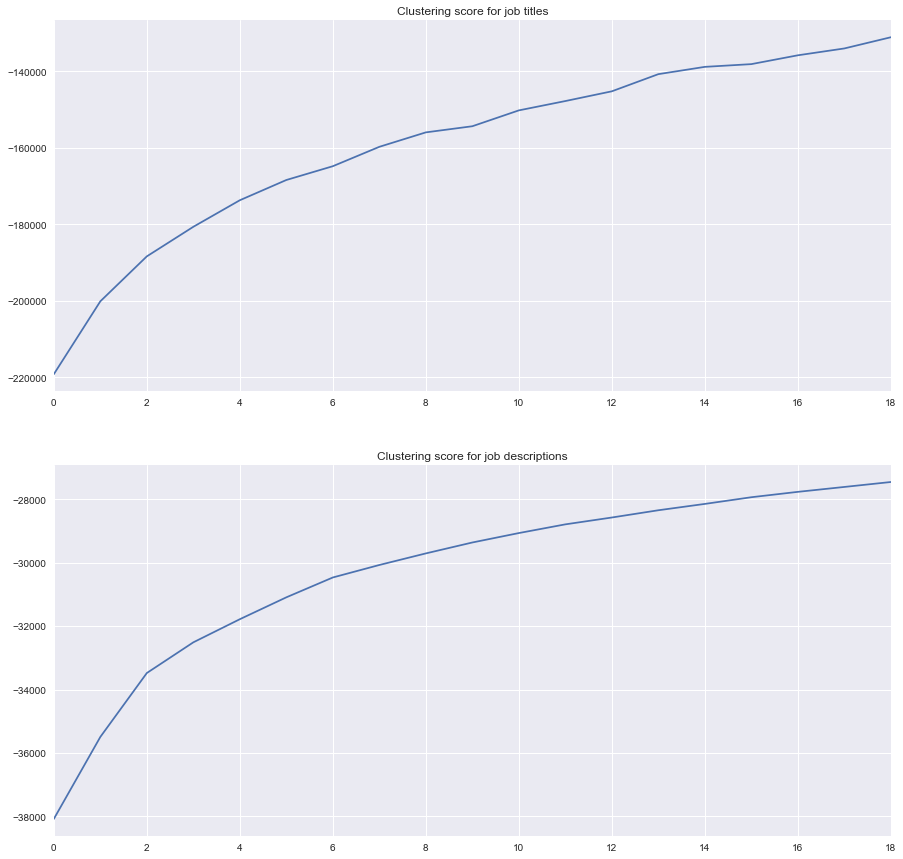

In [308]:
sns.set()
fig, axs = plt.subplots(nrows=2, figsize=(15,15))
pd.Series([i for i in scoreTitles]).plot(ax=axs[0])
pd.Series([i for i in scoreDescriptions]).plot(ax=axs[1])
axs[0].set_title('Clustering score for job titles')
axs[1].set_title('Clustering score for job descriptions')

In [309]:
# Find Silhouettes

In [310]:
silhouetteTitles   = [silhouette_score(vectorsTitles, kmeans[i + 1].fit_predict(vectorsTitles)) for i in range(len(kmeans) - 1)]
print('silhouetteTitles done.')
#silhouetteTitles   = [silhouette_score(vectorsTitles, kmeans[i + 1].fit_predict(vectorsTitles)) for i in range(len(kmeans) - 1)]

silhouetteDescriptions   = [silhouette_score(vectorsDescriptions, kmeans[i + 1].fit_predict(vectorsDescriptions)) for i in range(len(kmeans) - 1)]
print('silhouetteDescriptions done.')

silhouetteTitles done.
silhouetteDescriptions done.


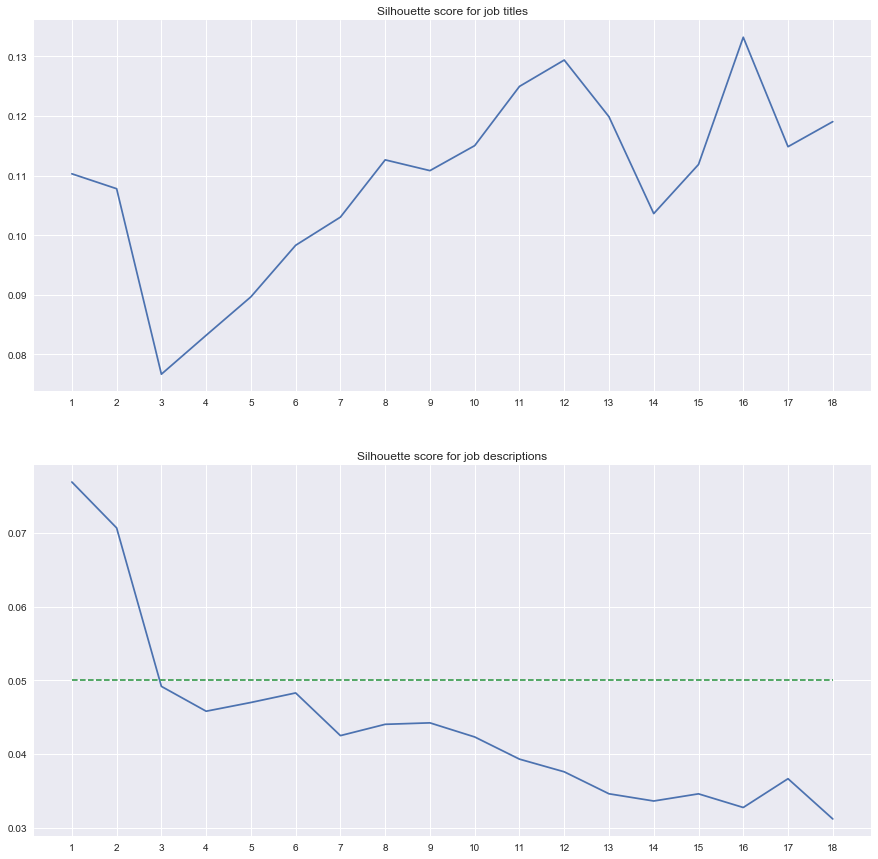

In [317]:
import matplotlib.ticker as plticker
silhouetteLabels = [k+1 for (k,v) in enumerate(silhouetteTitles)]
fig, axs = plt.subplots(nrows=2, figsize=(15,15))
loc = plticker.MultipleLocator(base=1.0)

axs[0].plot(silhouetteLabels, silhouetteTitles)
axs[0].xaxis.set_major_locator(loc)
axs[0].set_title('Silhouette score for job titles')

axs[1].plot(silhouetteLabels, silhouetteDescriptions)
axs[1].xaxis.set_major_locator(loc)
axs[1].set_title('Silhouette score for job descriptions')
axs[1].plot([1, 18], [0.05, 0.05], linestyle='dashed', lw=2)


# Pick number of clusters

In [253]:
numClusters = 11
clusterIDs = kmeans[numClusters].fit(vectorsTitles)
df['cluster'] = pd.Series(clusterIDs.labels_)

In [256]:
df

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Notes,AboutC,Attach,Year,Month,IT,cleanTitle,cleandesc,newcleandesc,cluster
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2004,1,False,Chief Financial Officer,AMERIA Investment Consulting Company seeking C...,AMERIA Investment Consulting Company seeking C...,11
1,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False,Country Coordinator,Public outreach strengthening growing network ...,Public outreach strengthening growing network ...,7
2,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2004,1,False,BCC Specialist,LEAD (Local Enhancement Development Health) BC...,LEAD (Local Enhancement Development Health) BC...,8
3,"Boutique ""Appollo""\r\nJOB TITLE: Saleswoman\r...","Jan 10, 2004",Saleswoman,"Boutique ""Appollo""",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2004,1,False,Saleswoman,Saleswoman sell menswear accessories.,Saleswoman sell menswear accessories.,6
4,OSI Assistance Foundation - Armenian Branch Of...,"Jan 11, 2004",Chief Accountant/ Finance Assistant,OSI Assistance Foundation - Armenian Branch Of...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2004,1,False,Chief Accountant Finance Assistant,Armenian Branch Office Open Society Institute ...,Armenian Branch Office Open Society Institute ...,11
5,American Embassy Yerevan\r\nANNOUNCEMENT NUMBE...,"Jan 13, 2004","Program Assistant (INL), FSN-8; FP-6*",American Embassy Yerevan\r\nANNOUNCEMENT NUMBE...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2004,1,False,Program Assistant INL FSN8 FP6,incumbent assists coordinating INL-funded law ...,incumbent assists coordinating INL-funded law ...,6
6,Institute for Sustainable Communities (ISC)\r\...,"Jan 13, 2004",Chief of Party (COP),Institute for Sustainable Communities (ISC),NaN,NaN,NaN,NaN,NaN,5 year\r\nPOSITION,...,NaN,Water User Associations Support Program (WUASP...,NaN,2004,1,False,Chief Party COP,ISC seeks experienced creative Chief Party (CO...,ISC seeks experienced creative Chief Party (CO...,11
7,Food Security Regional Cooperation and Stabili...,"Jan 14, 2004","Community Development, Capacity Building and C...",Food Security Regional Cooperation and Stabili...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2004,1,False,Community Development Capacity Building Conflict,Food Security Regional Cooperation Stability P...,Food Security Regional Cooperation Stability P...,7
8,"United Nations Development Programme, Armenia\...","Jan 15, 2004",Country Economist (NOB),"United Nations Development Programme, Armenia",NaN,NaN,NaN,NaN,NaN,3 months initial.,...,NaN,NaN,NaN,2004,1,False,Country Economist NOB,United Nations Development Programme Armenia a...,United Nations Development Programme Armenia a...,6
9,"Counterpart International, Inc.\r\nCounterpart...","Jan 16, 2004",Driver/ Logistics Assistant,"Counterpart International, Inc.\r\nCounterpart...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2004,1,False,Driver Logistics Assistant,Driver/ Logistics Assistant full-time national...,Driver/ Logistics Assistant full-time national...,4


### Show most popular words for each cluster

In [257]:

wordcount = {}
sorted_wordcount = {}
for i in range(numClusters):
    titles = df[df['cluster'] == i]["cleanTitle"].values
    titles = ' '.join(' '.join(titles).split())
    wordcount[i] = {}
    for j in titles.lower().split():
        if j in wordcount[i]: 
            wordcount[i][j] += 1
        else:
            wordcount[i][j] = 1
        
    sorted_wordcount[i] = sorted(wordcount[i].items(), key=lambda x: x[1], reverse=True)
    print(sorted_wordcount[i][0:15])
    print('---')


[('engineer', 1255), ('software', 432), ('senior', 340), ('qa', 254), ('department', 120), ('design', 80), ('quality', 71), ('c', 68), ('assurance', 64), ('submicron', 53), ('deep', 53), ('driver', 50), ('intern', 49), ('junior', 45), ('support', 44)]
---
[('accountant', 311), ('senior', 25), ('auditor', 22), ('cashier', 9), ('assistant', 7), ('outsourcing', 4), ('actuary', 3), ('management', 2), ('capex', 2), ('branch', 2), ('junior', 1), ('accounting', 1), ('time', 1), ('specialist', 1), ('bank', 1)]
---
[('manager', 1329), ('project', 161), ('branch', 94), ('office', 89), ('brand', 51), ('hr', 45), ('logistics', 40), ('finance', 39), ('development', 39), ('store', 38), ('department', 31), ('financial', 29), ('account', 29), ('customer', 29), ('product', 28)]
---
[('developer', 1697), ('software', 496), ('senior', 485), ('java', 286), ('c', 229), ('web', 220), ('net', 179), ('php', 169), ('programmer', 107), ('aspnet', 90), ('database', 76), ('android', 69), ('ios', 65), ('junior', 5

In [276]:
topwords = {}
for key, i in sorted_wordcount.items():
    print("Cluster "+str(key)+": ", end='')
    topwords[key] = ''
    for newkey, j in sorted_wordcount[key][0:4]:
        print(newkey + ' / ', end='')
        topwords[key] = topwords[key] + newkey + ' / '
    print()

Cluster 0: engineer / software / senior / qa / 
Cluster 1: accountant / senior / auditor / cashier / 
Cluster 2: manager / project / branch / office / 
Cluster 3: developer / software / senior / java / 
Cluster 4: assistant / administrative / receptionist / executive / 
Cluster 5: sales / manager / marketing / specialist / 
Cluster 6: translator / language / english / interpreter / 
Cluster 7: coordinator / head / development / officer / 
Cluster 8: specialist / medical / expert / representative / 
Cluster 9: designer / web / graphic / developer / 
Cluster 10: lawyer / journalist / legal / senior / 


In [277]:
#fig, ax = plt.subplots()
datecount = {}
for i in range(numClusters):
    dates = df[df['cluster'] == i]['Year'].values
    datecount[i] = {}
    for jobdate in dates:
        if jobdate in datecount[i]: 
            datecount[i][jobdate] += 1
        else:
            datecount[i][jobdate] = 1

datedf = pd.DataFrame(datecount)
datedf.drop('2015', axis=1)
# datedf.plot(ax=ax, figsize=(15,12))


# L=plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=int(numClusters/2))
# for i in range(numClusters):
#     L.get_texts()[i].set_text(topwords[i])


ValueError: labels ['2015'] not contained in axis

In [278]:
datedf.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')

### Normalize the view to see the trends

In [279]:
x = datedf.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normdf = pd.DataFrame(x_scaled)

#fig, ax = plt.subplots()

# normdf.plot(ax=ax, figsize=(15,12))

# L=plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=int(numClusters/2))

# for i in range(numClusters):
#     L.get_texts()[i].set_text(topwords[i])

C:\Anaconda3\envs\lsci\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


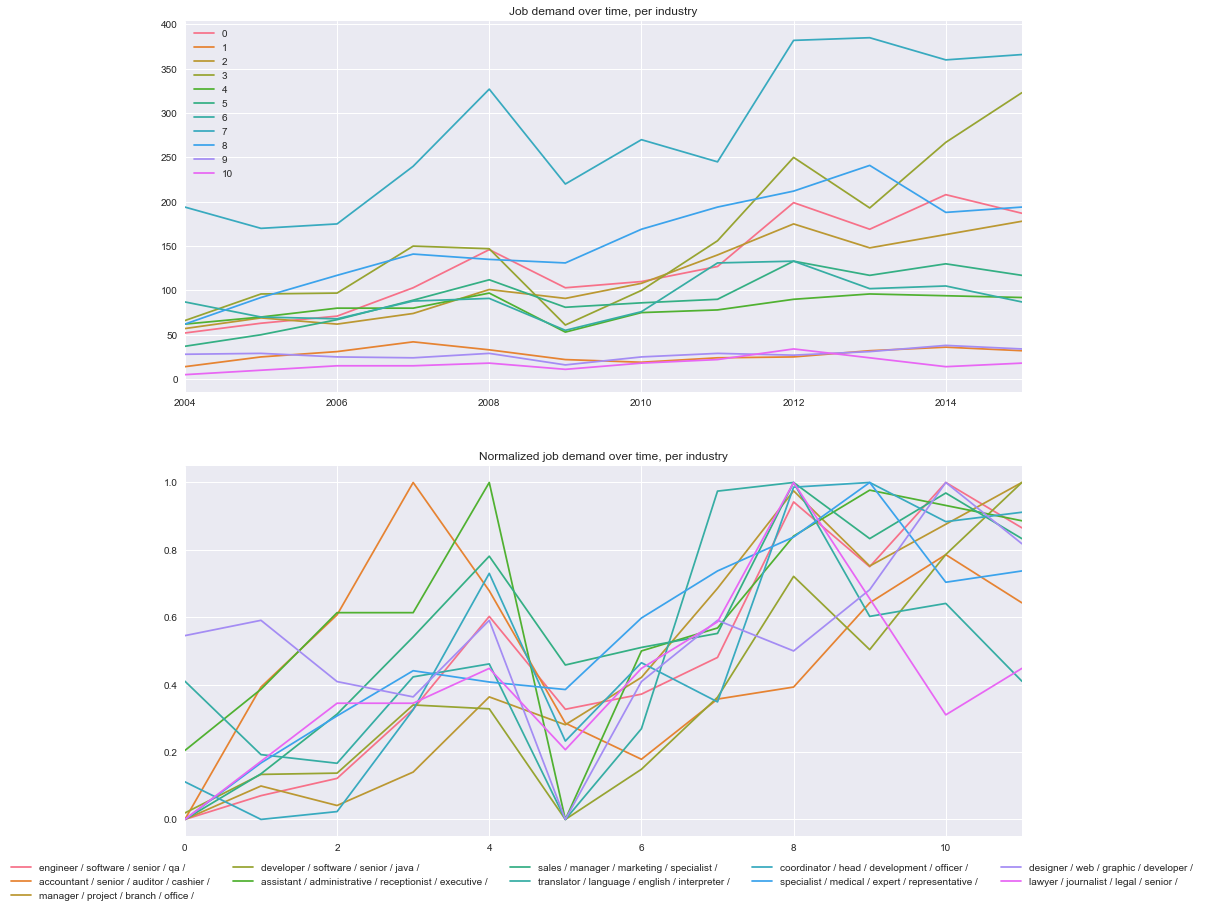

In [280]:
fig, axs = plt.subplots(nrows=2, figsize=(15,15))

sns.set_palette("husl", 12)  # oooh, pretty

datedf.plot(ax=axs[0])
normdf.plot(ax=axs[1])
axs[0].set_title('Job demand over time, per industry')
axs[1].set_title('Normalized job demand over time, per industry')

#L=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
L=plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=int(numClusters/2))
for i in range(numClusters):
    L.get_texts()[i].set_text(topwords[i])